<a href="https://colab.research.google.com/github/then00bprogrammer/Bot_Maker/blob/master/Transfer_Learning_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with TensorFlow part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to ours.
2. Can leverage a working neural network architecture which has already lerned patterns on similar data to our own, then we can adapt to those patterns to our own data.


##Downloading and becoming one with data

In [1]:
#Get the data (10% of 10 food classes from Food101)
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the downloaded file
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-11-07 09:37:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  24.0MB/s    in 7.8s    

2022-11-07 09:37:47 (20.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
#How many images in each folder?
import os

#Walk through 10% of data and list number of files and directories in each folder
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

There are 2 directories and 0 in 10_food_classes_10_percent
There are 10 directories and 0 in 10_food_classes_10_percent/test
There are 0 directories and 250 in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 in 10_food_classes_10_percent/test/chicken_curry
There are 10 directories and 0 in 10_food_classes_10_percent/train
There are 0 directories and 75 in 10_fo

##Create data loaders

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

IMAGE_SHAPE = (224,224)
BATCH_SIZE= 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images: ")
test_datagen_10_percent=test_datagen.flow_from_directory(test_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")



Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


##Callbacks: An Important concept (things to run whilst our model trains)
Callbacks in tensorflow can be used for different purposes:
* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve or ***overfits***. Helpful when you've got a large dataset and don't know how long training will take.

###1. TensorBoard Callback

In [4]:
#Create tensorboard callback
import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

##Creating Models Using Tensorflow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from Tensorflow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [5]:
#Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"

efficentnet_url="https://tfhub.dev/google/efficientnet/b0/feature-vector/1"



In [6]:
#Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
#Let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer
    and Dense output layer with num_classes output neurons.
  """

  #Download the pretrained model and save it as a keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="Feature_Extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,)
                                            ) #freeze the already learned patterns

  #Create our own model
  model = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])
    
  return model
    

###Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [8]:
#Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_layer (K  (None, 1001)             25615849  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 10,020
Non-trainable params: 25,615,849
_________________________________________________________________


In [10]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_datagen_10_percent,
                                  validation_steps=len(test_datagen_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")]
                                  )

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221107-093806
Epoch 1/5
24/24 [==============================] - 30s 759ms/step - loss: 2.2900 - accuracy: 0.3760 - val_loss: 1.3082 - val_accuracy: 0.5712
Epoch 2/5
24/24 [==============================] - 16s 686ms/step - loss: 0.9513 - accuracy: 0.6947 - val_loss: 0.8900 - val_accuracy: 0.7044
Epoch 3/5
24/24 [==============================] - 17s 750ms/step - loss: 0.6744 - accuracy: 0.7880 - val_loss: 0.8072 - val_accuracy: 0.7296
Epoch 4/5
24/24 [==============================] - 20s 859ms/step - loss: 0.5216 - accuracy: 0.8387 - val_loss: 0.7864 - val_accuracy: 0.7392
Epoch 5/5
24/24 [==============================] - 16s 691ms/step - loss: 0.4275 - accuracy: 0.8773 - val_loss: 0.7653 - val_accuracy: 0.7464


Wow!
Our Transfer Learning feature extractor model outperformed ALL of the previous models we built by hand...(substantially) and in a quicker training time AND with only 10% of the training examples.

In [12]:
#Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns seprate loss curves for training and validation metrics.

  Args:
    history: TensorFlow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """

  loss= history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="Training accuracy")
  plt.plot(epochs,val_accuracy,label="Val accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

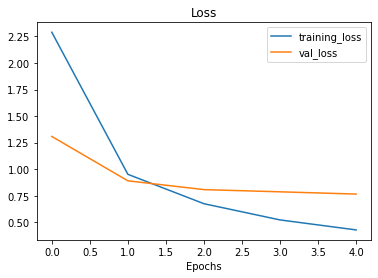

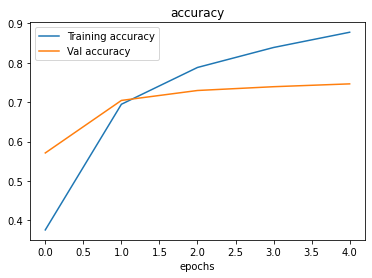

In [13]:
plot_loss_curves(resnet_history)

###Creating and testing EfficentNetB0 TensorFlow Hub Feature Extraction Model

In [14]:
efficentnet_model=create_model(efficentnet_url,train_data_10_percent.num_classes)

In [15]:
efficentnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

In [16]:
efficentnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [17]:
efficentnet_history=efficentnet_model.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_steps=len(test_datagen_10_percent),
                      validation_data=test_datagen_10_percent,
                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficentnet_bo")])

Saving TensorBoard log files to: tensorflow_hub/efficentnet_bo/20221107-093954
Epoch 1/5
24/24 [==============================] - 21s 750ms/step - loss: 1.7795 - accuracy: 0.4613 - val_loss: 1.2548 - val_accuracy: 0.7412
Epoch 2/5
24/24 [==============================] - 15s 659ms/step - loss: 1.0336 - accuracy: 0.7867 - val_loss: 0.8408 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 15s 661ms/step - loss: 0.7367 - accuracy: 0.8453 - val_loss: 0.6803 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 15s 653ms/step - loss: 0.5888 - accuracy: 0.8733 - val_loss: 0.5969 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 15s 652ms/step - loss: 0.4990 - accuracy: 0.8987 - val_loss: 0.5491 - val_accuracy: 0.8616


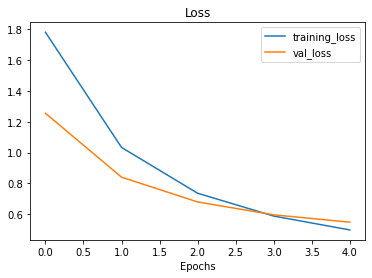

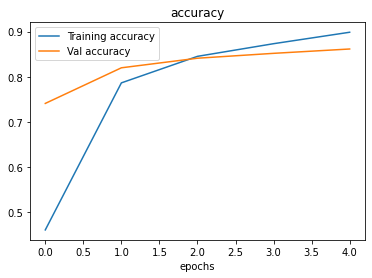

In [18]:
plot_loss_curves(efficentnet_history)

##Different types of transfer learning

* "**As is" transfer learning** - using an existing model with no changes what so ever(e.g. using ImageNet model on 1000 Imagenet classes, none of your own)
* **"Feature Extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficentNetBO trained on imageNet) and adjust the output layer for our own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all  of the underlying layers

##Comparing our Models with TensorBoard

> 🔑**Note:** When you upload things to tensorboard.dev, your experiments are public. So if you're running a private experiment (things you don't want other people to see) don't upload them to TensorBoard.dev.

In [19]:

# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficentNetBo vs. ResNet50V2" \
--description "Comparing two different TF Hub extraction model architectures using 10% of the training data" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=nHIn8HLtbPouPMQIllflqwJ4di68PI&prompt=consent&access_type=off

Our experiments are uploaded publically here https://tensorboard.dev/experiment/fJOBBU5YTMmeHJnoUELLgA/

In [20]:
#Checkout what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/1FZDbhmARPyZ26aYQKLNTg/
	Name                 EfficentNetBo vs. ResNet50V2
	Description          Comparing two different TF Hub extraction model architectures using 10% of the training data
	Id                   1FZDbhmARPyZ26aYQKLNTg
	Created              2022-11-07 09:46:46 (11 seconds ago)
	Updated              2022-11-07 09:46:52 (5 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3158170
https://tensorboard.dev/experiment/fJOBBU5YTMmeHJnoUELLgA/
	Name                 EfficentNetBo vs. ResNet50V2
	Description          Comparing two different TF Hub extraction model architectures using 10% of the training data
	Id                   fJOBBU5YTMmeHJnoUELLgA
	Created              2022-09-26 14:22:35
	Updated              2022-09-26 14:22:40
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3158238
Total

In [21]:
#Delete an experiment
# !tensorboard dev delete --experiment_id fJOBBU5YTMmeHJnoUELLgA

In [22]:
#Confirm the deletion by rechecking what experiments you have left
!tensorboard dev list

https://tensorboard.dev/experiment/1FZDbhmARPyZ26aYQKLNTg/
	Name                 EfficentNetBo vs. ResNet50V2
	Description          Comparing two different TF Hub extraction model architectures using 10% of the training data
	Id                   1FZDbhmARPyZ26aYQKLNTg
	Created              2022-11-07 09:46:46 (15 seconds ago)
	Updated              2022-11-07 09:46:52 (9 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3158170
https://tensorboard.dev/experiment/fJOBBU5YTMmeHJnoUELLgA/
	Name                 EfficentNetBo vs. ResNet50V2
	Description          Comparing two different TF Hub extraction model architectures using 10% of the training data
	Id                   fJOBBU5YTMmeHJnoUELLgA
	Created              2022-09-26 14:22:35
	Updated              2022-09-26 14:22:40
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3158238
Total